# Как делать графики и таблицы в питоне по-красоте

Предполагается, что вы знаете как работает питон и все использованные здесь библиотеки. Если че-то непонятно, гуглите.

### Шаг первый
Вставляем это в начале кода

In [1]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Эти 2 строки сохраняют пустой график с названием 1.pgf. 
# Хз зачем это, если у вас будет работать без этого, можно смело удалять.
plt.savefig('data/1.pgf')
plt.show()


matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

<Figure size 432x288 with 0 Axes>

В tex файл надо импортнуть pgfplots

```
\usepackage{pgfplots}
```

### Шаг второй

Записываем наши таблицы в формате csv и считываем их. Посмотрите файлы в папке data, там пример данных. Записать данные в csv можно либо в excel, либо просто в блокноте.

In [2]:
# функция, считывающая сразу несколько файлов(на вход идут пути к ним)
def read_files(files):
    ret = []
    for f in files:
        ret += [pd.read_csv(f)]
    return ret

Считываем файлы

In [3]:
geig, spectrum = read_files(['data/tab1.csv', 'data/spectrum.csv'])

### Шаг третий
Выполним небольшую обработку данных

В качестве примера я рассматриваю работу 5.4.1, в которой надо подобрать параметры нетривиальной функции под данные, а потом вычислить её производную. Если вам надо просто нарисовать точки, переходите к четвёртому шагу.

В данном случае наша функция $$N(x) = \frac{A}{1+e^{\alpha(x-x_0)}}$$ соответственно у нас 3 параметра: $A, \alpha$ и $x_0$.

In [4]:
# par[0] = A
# par[1] = alpha
# par[2] = x0
def sigmoid(par, x):
    return par[0]/(1 + np.exp(par[1]*(x-par[2])))

Вот эта имба подбирает параметры к вашей функции(наименьший квадрат ошибки), если она задана в формате, приведённом выше

In [5]:
def fit(f, params, x, y):
    """Аргументы:
        f - функция, которую мы хотим оптимизировать.
        params - начальное состояние параметров, можно просто передать нули, 
            главное чтоб их было нужное количество
        x, y - точки, под которые подгоняем функцию
    """
    if len(x) != len(y):
        raise "Иксов должно быть столько же, сколько и игреков"
    def err(par, x_, y_):
        y1 = f(par, x_)
        return np.sum((y1-y_)**2)
    
    return minimize(err, params, args=(x, y)).x

Чтоб вы поняли, с чем мы имеем дело, вот наши данные(первые несколько точек)

In [6]:
geig.head()

,l,N,t
0,10,14,72
1,5,439,30
2,1,411,30
3,8,242,30
4,9,42,30


Мы хотим подогнать функцию под точки $(I;N/t)$. Сначала создадим столбец в таблице, где будет посчитана $N/t$

In [7]:
geig['N1'] = geig['N'] / geig['t']

Подгоняем функцию

In [8]:
par = np.zeros((3,))
par = fit(sigmoid, par, geig['l'], geig['N1'])

print(f'A = {par[0]}, alpha = {par[1]}, x0 = {par[2]}')

A = 14.20390254820025, alpha = 2.707506281046367, x0 = 8.115884956009317


#### Более простой случай

Возможно вам придётся подгонять более простую функцию, например многочлен, вот ещё пример как это делать

In [9]:
# 2 - степень многочлена, cov мы не используем
poly, cov = np.polyfit(spectrum['T'], spectrum['A'], 2, cov=True)

### Шаг четвёртый
Наконец рисуем графики

/tmp/ipykernel_35240/953711285.py:26: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


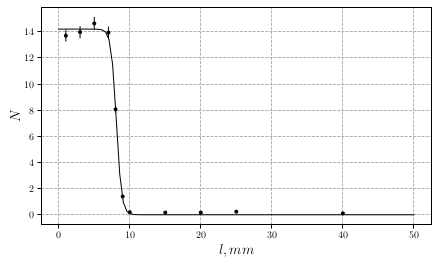

In [10]:
# Размер графика
fig = plt.figure(figsize=(7, 4))

#задаем отрезок, на котором рисуем кривую
x = np.linspace(0, 50, num=100)
#рисуем кривую
plt.plot(x, sigmoid(par, x), 'k', linewidth=1, label='N approximation')

# Надо еще погрешности посчитать
delta_N = geig['N'] / geig['t']**2

#рисуем точки
plt.errorbar(geig['l'], geig['N1'], fmt='k.', yerr=delta_N, xerr=0, linewidth=1, label='measurments')

#вариант без погрешностей
#plt.plot(geig['l'], geig['N1'], 'k.', linewidth=1, label='measurments')

#Оформление
plt.grid(linestyle='--')
plt.xlabel('$l, mm$', fontsize=15)
plt.ylabel('$N$', fontsize=15)
# fig.legend()

#Сохраняем результат
plt.savefig('data/geig.pgf')
plt.show()

Пример графика многочлена

/tmp/ipykernel_35240/1272136587.py:10: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


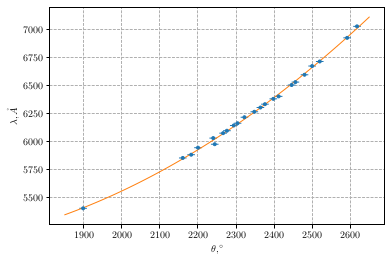

In [11]:
plt.errorbar(spectrum['T'], spectrum['A'], xerr=10, yerr=0, fmt='.', linewidth=1)
x = np.linspace(1850, 2650, num=100)
plt.plot(x, np.polyval(poly, x), linewidth=1)

plt.grid(linestyle='--')
plt.xlabel('$\\theta, ^\circ$')
plt.ylabel('$\lambda, \mathring{A}$')

plt.savefig('data/spectrum.pgf')
plt.show()

В tex файл импортируем график вот так:

```
\begin{figure}[h!]
    \centering
    \input{data/geig.pgf}
    \caption{Зависимость потока $\alpha$-частиц от расстояния до источника}  
\end{figure}
```

### Шаг пятый
Мы уже написали таблицу в csv файл, разумеется переписывать её ещё раз в tex таблицу мы не будем

In [12]:
# float_format определяет точность вывода вещественных чисел
print(geig.to_latex(index=False, float_format='%.2f'))

\begin{tabular}{rrrr}
\toprule
 l &   N &   t &    N1 \\
\midrule
10 &  14 &  72 &  0.19 \\
 5 & 439 &  30 & 14.63 \\
 1 & 411 &  30 & 13.70 \\
 8 & 242 &  30 &  8.07 \\
 9 &  42 &  30 &  1.40 \\
40 &  12 & 113 &  0.11 \\
 3 & 419 &  30 & 13.97 \\
 7 & 418 &  30 & 13.93 \\
15 &  18 & 107 &  0.17 \\
20 &  18 & 107 &  0.17 \\
25 &  22 &  93 &  0.24 \\
\bottomrule
\end{tabular}



Придётся вручную её подправить, но всё равно это быстрее, чем с нуля её писать

Обработку таблицы можно ещё чуть-чуть упростить

In [13]:
def latex_tab(df):
    tab = df.to_latex(index=False, float_format='%.2f')
    tab = tab.replace('\\\\\n', '\\\\ \\hline\n')
    tab = tab.replace('\\toprule', '\\hline')
    tab = tab.replace('\\midrule\n', '')
    tab = tab.replace('\\bottomrule\n', '')
    return tab

In [14]:
print(latex_tab(geig))

\begin{tabular}{rrrr}
\hline
 l &   N &   t &    N1 \\ \hline
10 &  14 &  72 &  0.19 \\ \hline
 5 & 439 &  30 & 14.63 \\ \hline
 1 & 411 &  30 & 13.70 \\ \hline
 8 & 242 &  30 &  8.07 \\ \hline
 9 &  42 &  30 &  1.40 \\ \hline
40 &  12 & 113 &  0.11 \\ \hline
 3 & 419 &  30 & 13.97 \\ \hline
 7 & 418 &  30 & 13.93 \\ \hline
15 &  18 & 107 &  0.17 \\ \hline
20 &  18 & 107 &  0.17 \\ \hline
25 &  22 &  93 &  0.24 \\ \hline
\end{tabular}



Дополнения к гайду приветствуются ;)